In [1]:
import os
import sys
import numpy as np

from IPython.display import display, HTML

import pickle

import torch

import matplotlib.pyplot as plt




import seaborn as sns
# Set up some parameters for pretty plots
import matplotlib as mpl
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Colors & styles adjustments for better visibility on both backgrounds
text_and_line_color = '#808080'
plt.rcParams['text.color'] = text_and_line_color
plt.rcParams['axes.labelcolor'] = text_and_line_color
plt.rcParams['xtick.color'] = text_and_line_color
plt.rcParams['ytick.color'] = text_and_line_color
plt.rcParams['axes.edgecolor'] = text_and_line_color


sys.path.append("..")
%load_ext autoreload
%autoreload 2


# import encoder/decoder, and some html visualization utils
from  interp_utils import *


out_dir='..'


## Load and analyze the model

In [24]:
from model import GPTConfig, GPT

torch.set_grad_enabled(False) # only inference, no need for gradients




device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 1337234
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # I'm using the dtypes used for training.


torch.manual_seed(seed)
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
if device_type == 'cuda':
    torch.cuda.manual_seed(seed)

# aligning with the original nanaoGPT config
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]




# Load the GPT model
checkpoint = torch.load('../parliment_names_out/ckpt.pt', map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict, strict=False)


# This is for later use. I changed the model in a very lazy way to be able to both load it and hook onto it. I'll explain more below.
# Iterate over each attention layer in the model and register a bias for causal attention
for i, block in enumerate(model.transformer.h):
    attn = block.attn
    if not hasattr(attn, 'bias') or attn.bias is None:
        print(f"Initializing missing 'bias' in layer {i}")
        # Initialize the bias
        block_size = gptconf.block_size
        attn.register_buffer("bias", torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size))


model.eval()
model.to(device)


number of parameters: 11.08M
Initializing missing 'bias' in layer 0
Initializing missing 'bias' in layer 1
Initializing missing 'bias' in layer 2
Initializing missing 'bias' in layer 3
Initializing missing 'bias' in layer 4
Initializing missing 'bias' in layer 5


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(1197, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=1197, bias=False)
)

### Generate some text:

In [25]:
# -----------------------------------------------------------------------------
start = "\n" # messeges start with a newline
num_samples = 1 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 300 # retain only the top_k most likely tokens, clamp others to have 0 probability
# -----------------------------------------------------------------------------





start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

torch.manual_seed(seed)
# run generation

for k in range(num_samples):
    y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
    print(decode_member(y[0].tolist()))
    print('---------------')


[06/03/2021, 9:04:30] Member 2: אוקיי אני רציני מאוד שאולי בבית
[06/03/2021, 9:04:40] Member 2: לא הבנתי. ואין הרבה יותר מאוד חרא. נראה שזה מכוון להישאר בניו יורק הכנסה. הרוב צפון והיו פרסם בפסטה, ויהיה צילם אילון והיא זה הדבר הכי מושך לשימוש בעל רקע.
[06/03/2021, 9:04:53] Member 9: מאוד מאמין שאני מודה בתחום הראשון שלי במקום העניין
[06/03/2021, 9:10:38] Member 6: נפלא
[06/03/2021, 9:10:58] Member 2: לא יודע אם היתה יריקה עם המלון ללא הפיתוח אחרת השנים האחרונים שגם לא מתחיל
[06/03/2021, 9:11:04] Member 4: כן, לא צריך לשכוח לו את ההליסטוריה הנושאים שהגיעו לכל ה
---------------


Sorry, we text in Hebrew. But, look how nice the generated time stamps are ordered!

Observations:
1. our model correctly learned the structure of text messages; it starts with a time stamp, followed by the sender's name, and then the message. E.g. '[12/12/2018, 12:34:56] Sender: Message'
2. Very nicely, the time stamp of generated messages is increasing, as long as the message is short enough to fit into the sequence length.

Hypotheses:
1. Each time stamp attends to the previous time stamp. 
2. In deep layers, there is a feature that captures the sequential nature of the time stamps. 

### Length of messages:

For this to be reasonable, we should see that the models saw short enough messages to fit into the sequence length of 256.
We are going to be lazy and just count the number of characters between each '\n', which is the length of the message, up to cases where the message itself contains a line break, but we will assume this is rare. 

We show below that this is not a crazy assumption. 
(For obvious reasons, I did not include the text, so can't really reproduce the results here. )

Here is the resulting plot:

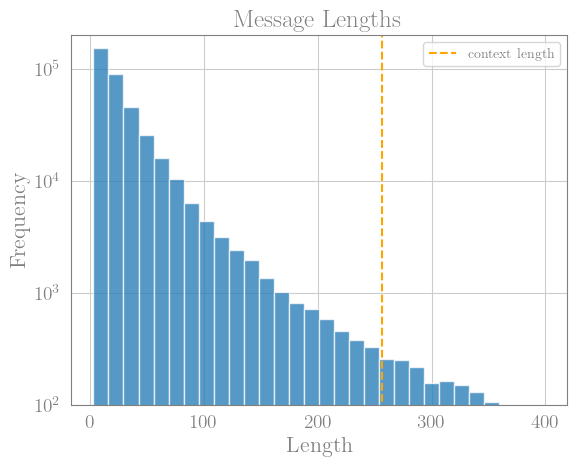

We see that indeed most messages are quite shorter than sequence length, along the model to actually attend to previous time stamps.

### Simple next character prediction:

Now, we prompt the model with a message and a time stamp prefix, and check what are the predicted logits for the next character.

In [ ]:
with open('../data/parliment/input.txt', 'r') as f:
    full_chat = f.read()


import re
# Regular expression to match the start of each message
message_start_pattern = r"\[\d{2}/\d{2}/\d{4}, \d{1,2}:\d{2}:\d{2}\] [^:]+:"

# Find all matches and their positions
matches = list(re.finditer(message_start_pattern, full_chat))


chars_between_messages = []
for i in range(len(matches) - 1):
    end_of_first_message = matches[i].end()
    start_of_next_message = matches[i + 1].start()
    
    # Calculate the number of characters in between
    chars_between = start_of_next_message - end_of_first_message
    chars_between_messages.append(chars_between)

# Plot
chars_between_messages=np.array(chars_between_messages)
hist=plt.hist(chars_between_messages[chars_between_messages<400], bins=30, alpha=0.75, density=False)
plt.title('Message Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.vlines(256, 0, 1e6, colors='orange', linestyles='dashed', label='context length')
plt.legend()
plt.ylim(1e2, 2e5)
plt.yscale('log')

plt.show()

In [33]:
sample_text='[04/11/2022, 18:29:50'+member_tokens[1]+'Some text.\n[04/11/2022, 18:'
ids = encode(sample_text)
x = torch.tensor([ids], dtype=torch.long).to(device)

# Get logits and probabilities
logits, _ = model(x)
probs = torch.softmax(logits, dim=-1)

# Get the top 10 most likely tokens after the sample text
topk = torch.topk(probs, 10)
topk_indices = topk.indices.cpu().numpy().flatten()
topk_probs = topk.values.cpu().numpy().flatten()

for (i, p) in zip(topk_indices, topk_probs):
    print(f'next token: {itos[i]}, probability: {100*p:.2f}%')

next token: 3, probability: 66.61%
next token: 2, probability: 25.46%
next token: 4, probability: 6.09%
next token: 5, probability: 1.64%
next token: 1, probability: 0.11%
next token: 0, probability: 0.08%
next token: e, probability: 0.00%
next token: ת, probability: 0.00%
next token: :, probability: 0.00%
next token: q, probability: 0.00%


It is very nice to see that the model gives non-negligible probability only to timestamps that are in the future of the given timestamp.
Next, we want to claim that there the model learned that some members are replied to faster than others. 

In [34]:
for j, token in enumerate(member_tokens):
    sample_text='[04/11/2023, 18:21:13'+token+'Yesterday I woke up sucking a lemon.\n[04/11/2023, 18:2'
    ids = encode(sample_text)
    x = torch.tensor([ids], dtype=torch.long).to(device)

    # Get logits and probabilities
    logits, _ = model(x)
    probs = torch.softmax(logits, dim=-1)

    # Get the top 10 most likely tokens after the sample text
    topk = torch.topk(probs, 2)
    topk_indices = topk.indices.cpu().numpy().flatten()
    topk_probs = topk.values.cpu().numpy().flatten()
    print(f'----Member {j+1}----')
    for (i, p) in zip(topk_indices, topk_probs):
        print(f'next token: {itos[i]}, probability: {100*p:.2f}%')
    

----Member 1----
next token: 1, probability: 58.97%
next token: 2, probability: 16.88%
----Member 2----
next token: 1, probability: 60.41%
next token: 2, probability: 16.13%
----Member 3----
next token: 1, probability: 60.66%
next token: 2, probability: 16.17%
----Member 4----
next token: 1, probability: 62.49%
next token: 2, probability: 16.00%
----Member 5----
next token: 1, probability: 60.96%
next token: 2, probability: 16.17%
----Member 6----
next token: 1, probability: 66.02%
next token: 2, probability: 14.98%
----Member 7----
next token: 1, probability: 61.09%
next token: 2, probability: 15.72%
----Member 8----
next token: 1, probability: 59.51%
next token: 2, probability: 16.68%
----Member 9----
next token: 1, probability: 60.59%
next token: 2, probability: 16.58%


We see that the model think we are all usually answered within less than a minute (😂 probably we should give each other some more space!). Also, member 6 has the highest probability of being answered fast!

## Attention heads visualization

As I said earlier, I needed to change the model in a silly way to be able to hook on the attention weights. The model was trained using flash attention, and I wanted to simply calculate the $QK^T$ matrix. So this is what I did:
Original code:
```python
if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        ...
```

I suplemented it with a redundant calculation of the $QK^T$ matrix:
```python
if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            self.att_amps = att # for simple hook
        ... 
```

In [35]:
# Load a "Visualizer" from my interp_utils
visualizer = AttentionVisualizer(model, device)

# Prompt the model and keep the attention scores
member = member_tokens[0]
prompt = f'[04/11/2023, 18:22:21{member}random text.\n[04/11/2023, 18:2'
visualizer.prompt(prompt)

for member in member_tokens:
        prompt = f'[04/11/2023, 18:22:21{member}Yesterday I woke up sucking a lemon.\n[04/11/2023, 18:'
        visualizer.prompt(prompt)

Below we show the attention head that seem to attend to the same location in the previous timestamp when generating a new timestamp.

In [36]:
# Show specifc heads
layer_head_pairs = [(3, 0),(3, 2), (4,0), (4, 1), (4, 4), (4, 5), (5, 3)]
html_output = visualizer.visualize_specific_attention(layer_head_pairs=layer_head_pairs,num_last_tokens=8,show_layer_head_info=True)

display(HTML(html_output))

[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,,,,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,,,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,1,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,1,8,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,,,,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,,,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,,,,


I was really happy to see the specific head below (4,3). This one seems to attend to the next position in the previous timestamp. This is a very nice feature, as it allows the model to generate the time stamps in a very meaningful way.

In [31]:
display(HTML(visualizer.visualize_specific_attention([(4,3)],8,show_layer_head_info=True)))

[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,,,,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,,,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,1,,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,1,8,,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,
[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2,2,:,2,1,] Member 1:,r,a,n,d,o,m,,t,e,x,t,.,,[,0,4,/,1,1,/,2,0,2,3,",",,1,8,:,2


Below we show a few heads that seem to attend to previous sender's name when generating a new timestamp. This is also a very nice feature, it seems that the model learned that each member is subject to a different 'reaction time'.

In [32]:
layer_head_pairs = [(3, 3), (5, 4), (5,5)]

html_output_all = visualizer.visualize_multiple_attention(layer_head_pairs=layer_head_pairs, show_layer_head_info=True)
display(HTML(html_output_all))